In [1]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

clear_output()

from nnsight import CONFIG

In [2]:
# Load llama3.1
llama = LanguageModel("meta-llama/Meta-Llama-3.1-8B",device="cuda")
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [3]:
import torch.nn.functional as F
import numpy as np

# run the logit lens on a list of prompts
def run_prompts(model,prompts,target_tokens=None):
    output = zip(
        *[run_lens(model, prompt, target_tokens) for prompt in prompts]
    )
    return output

# run the logit lens on a single prompt, with a list of target tokens
def run_lens(model,PROMPT,target_tokens=None):
    if not target_tokens:
        lens_target_tokens, lens_token_result, lens_token_probs, lens_token_ranks, lens_token_entropy, lens_token_kldiv =logitlens(model,PROMPT)
    
        return [lens_target_tokens], [lens_token_result], [lens_token_probs], [lens_token_ranks], [lens_token_entropy], [lens_token_kldiv]

    
    target_tokens = [torch.tensor(model.tokenizer.encode(target)[1:]) for target in target_tokens]
    lens_target_tokens = []
    lens_token_result = []
    lens_token_probs = []
    lens_token_ranks = []
    lens_token_entropy = []
    lens_token_kldiv = []
    for target_token in target_tokens:
        actual_output, logit_lens_results, logit_lens_all_probs,logit_lens_ranks_by_layer,logit_lens_entropy_by_layer,logit_lens_Kldiv_by_layer= logitlens(model,PROMPT,target_token)
        lens_target_tokens.append(actual_output)
        lens_token_result.append(logit_lens_results)
        lens_token_probs.append(logit_lens_all_probs)
        lens_token_ranks.append(logit_lens_ranks_by_layer)
        lens_token_entropy.append(logit_lens_entropy_by_layer)
        lens_token_kldiv.append(logit_lens_Kldiv_by_layer)

    return lens_target_tokens,lens_token_result,lens_token_probs,lens_token_ranks,lens_token_entropy,lens_token_kldiv

    
# run the logit lens on a single prompt with one target token
def logitlens(model,PROMPT,target_token=None):
    result_by_layer = []
    probs_by_layer = []
    ranks_by_layer = []
    entropy_by_layer = []
    KLdiv_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            # Get the hidden state for the current layer
            hidden_state = layer.output[0][0]
            logit_lens_normed_last_token = model.model.norm(hidden_state)
            logit_lens_token_distribution = model.lm_head(logit_lens_normed_last_token)
            logit_lens_last_token_logit = logit_lens_token_distribution[-1:]

            # Calculate probabilities using softmax
            logit_lens_probs = F.softmax(logit_lens_last_token_logit, dim=1).save()
            probs_by_layer.append(logit_lens_probs)

            # Get the next token predicted by the model
            logit_lens_next_token = torch.argmax(logit_lens_probs, dim=1).save()
            result_by_layer.append(logit_lens_next_token)
        
        # Get the model's prediction if target_token is not specified
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        if target_token is None:
            target_token = tokens_out[0][-1].save()
            
    #get the rank of the expected token from each layer's distribution
    for layer_probs in probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token. 1-based
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        expected_token_rank = (sorted_indices == target_token).nonzero(as_tuple=True)[1].item() + 1
        ranks_by_layer.append(expected_token_rank)

        # Calculate entropy for the current layer
        entropy = -(layer_probs * layer_probs.log()).sum(-1).item()
        entropy_by_layer.append(entropy)
        
        # Calculate KL divergence between the current layer and the final layer
        KL_div = (layer_probs * (layer_probs.log()-probs_by_layer[-1].log())).sum(-1).item()
        KLdiv_by_layer.append(KL_div)
    
    probs_by_layer = np.concatenate([probs[:, target_token].cpu().detach().to(torch.float32).numpy() for probs in probs_by_layer])
    logit_lens_target = llama.tokenizer.decode(target_token.item())
    results_by_layer = [model.tokenizer.decode(next_token.item()) for next_token in result_by_layer]
    return logit_lens_target,results_by_layer, probs_by_layer,ranks_by_layer,entropy_by_layer,KLdiv_by_layer

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

def plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_data, plot_type, lower_bound=None, upper_bound=None):
    warnings.filterwarnings("ignore", "Glyph .* missing from font", UserWarning)
    
    plt.figure(figsize=(10, 6))
    
    # Determine the y-axis behavior based on the plot_type and diff_factor
    for i in range(len(logit_lens_data)):
        item_data = logit_lens_data[i]
        
        if plot_type in ['entropy', 'kldiv']:  # Apply diff_factor if specified
            item_data = np.maximum(item_data, 1e-1)  # e.g., apply log scaling or offset
            
        plt.plot(range(len(item_data)), item_data, marker='x')
        if lower_bound is not None and upper_bound is not None:
            lower_bound=lower_bound[i]
            upper_bound=upper_bound[i]
            x = np.arange(len(item_data))
            
            if plot_type in ['entropy', 'kldiv']:  # Apply diff_factor if specified
                lower_bound = np.maximum(lower_bound, 1e-2)  # e.g., apply log scaling or offset
            # Plot the shaded confidence interval
            plt.fill_between(
                x, 
                lower_bound,
                upper_bound,
                color='blue', 
                alpha=0.2,  # Transparency
                label="95% Confidence Interval"
            )

        if logit_lens_results:
            item_results = logit_lens_results[i]
            for layer_number, next_token in enumerate(item_results):
                plt.text(layer_number, item_data[layer_number], next_token, ha='right', va='bottom')
    
    # Set y-axis scale for entropy and kldiv
    if plot_type in ['entropy', 'kldiv']:
        plt.yscale('log')
    
    # Add legend if targets are provided
    if logit_lens_targets and plot_type not in ['entropy', 'kldiv']:
        plt.legend(logit_lens_targets)
    
    # Set common labels and title
    plt.xlabel('Layer Number')
    if plot_type == 'probs':
        plt.ylabel('Probability of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'ranks':
        plt.ylabel('Rank of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'entropy':
        plt.ylabel('Entropy of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'kldiv':
        plt.ylabel('KL Divergence of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    
    plt.grid(True)
    plt.show()


Running logit lens on a single prompt

In [59]:
PROMPT = "The Eiffel Tower is in "
logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[' Paris',' France'])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv = run_lens(llama,PROMPT,[PROMPT.split()[-1]])

2024-12-01 17:43:31,727 4acbd101-7289-48bf-9141-ee918fb78385 - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 17:43:31,762 4acbd101-7289-48bf-9141-ee918fb78385 - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 17:43:31,818 4acbd101-7289-48bf-9141-ee918fb78385 - RUNNING: Your job has started running.
2024-12-01 17:43:32,464 4acbd101-7289-48bf-9141-ee918fb78385 - COMPLETED: Your job has been completed.
2024-12-01 17:43:33,137 f1310489-4a63-4d7c-84f3-3460f8f82f0f - RECEIVED: Your job has been received and is waiting approval.
2024-12-01 17:43:33,201 f1310489-4a63-4d7c-84f3-3460f8f82f0f - APPROVED: Your job was approved and is waiting to be run.
2024-12-01 17:43:33,245 f1310489-4a63-4d7c-84f3-3460f8f82f0f - RUNNING: Your job has started running.
2024-12-01 17:43:33,868 f1310489-4a63-4d7c-84f3-3460f8f82f0f - COMPLETED: Your job has been completed.


In [ ]:
# Example usage
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_probs, plot_type='probs')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_ranks, plot_type='ranks')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_entropy, plot_type='entropy')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_kldiv, plot_type='kldiv')

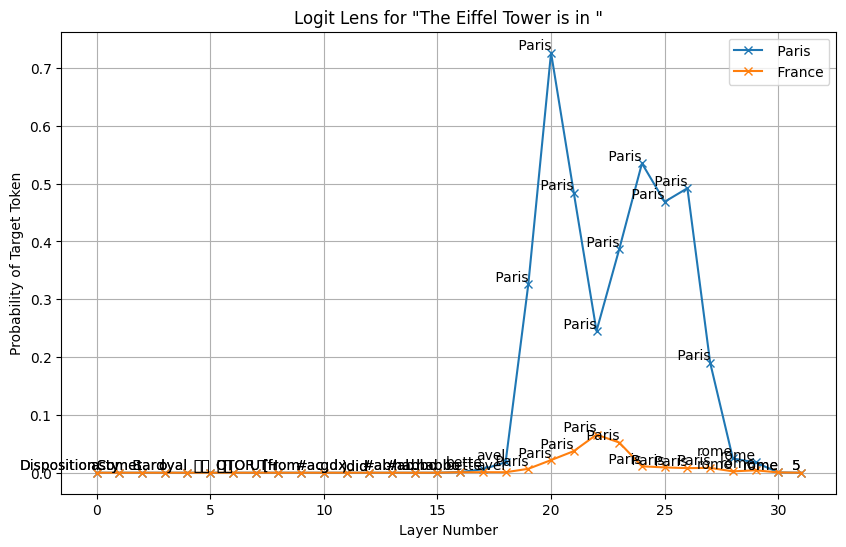

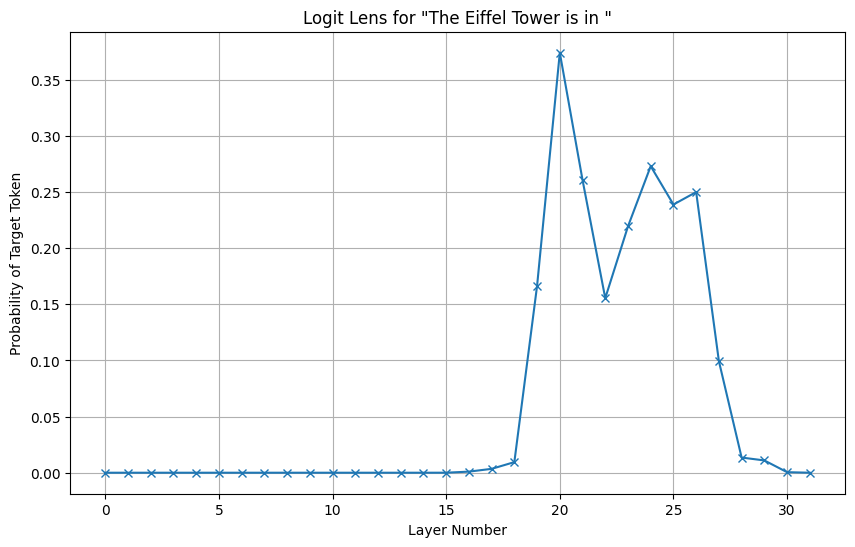

In [66]:
#plot one line each
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_probs, plot_type='probs')

def compute_conf_interval(data, confidence=0.95):
    n = data.shape[0]  # Number of samples
    se = np.std(data, axis=0, ddof=1) / np.sqrt(n)  # Standard error
    z = 1.96  # Z-value for 95% confidence
    return z * se  # Shape matches the mean shape


#take the mean 
# print(logit_lens_probs)
mean_probs  = [np.mean(np.stack(logit_lens_probs), axis=0)]
plot_lens(PROMPT,None, None, mean_probs, plot_type='probs')


# #take the difference
# diff_probs  = [np.stack(logit_lens_probs)[0] - np.stack(logit_lens_probs)[1]]
# diff_ranks = [np.stack(logit_lens_ranks)[0] - np.stack(logit_lens_ranks)[1]]
# plot_lens(PROMPT,None, None, diff_probs, plot_type='probs')

Running logit lens accross a list of prompts

In [ ]:
prompts= ["The Eiffel Tower is in the city of","Vatican is located in the city of","The Louvre Museum is in the city of","The White House is in the city of","The Statue of Liberty is in the city of","The Sydney Opera House is in the city of","The Taj Mahal is in the city of","The Pyramids of Giza are in the city of","The Colosseum is in the city of"]
prompts_target_tokens, prompts_token_result, prompts_token_probs, prompts_token_ranks, prompts_token_entropy, prompts_token_kldiv = run_prompts(llama,prompts)

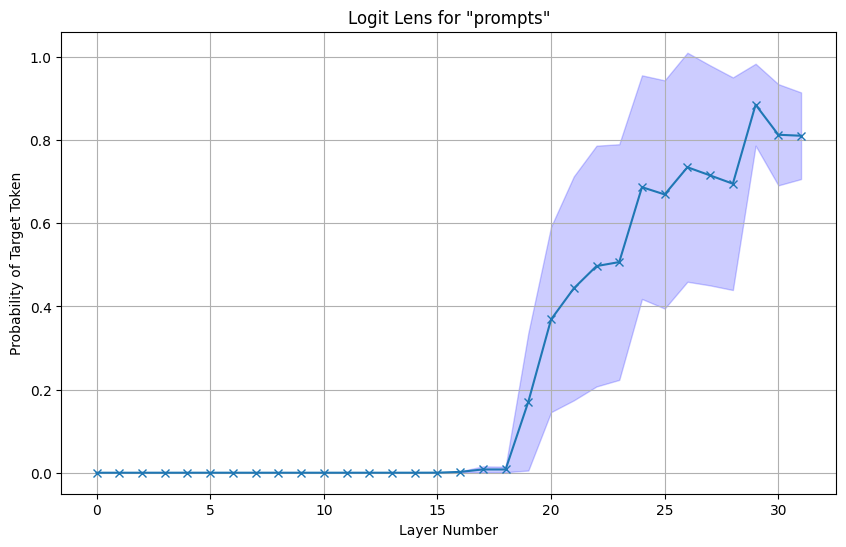

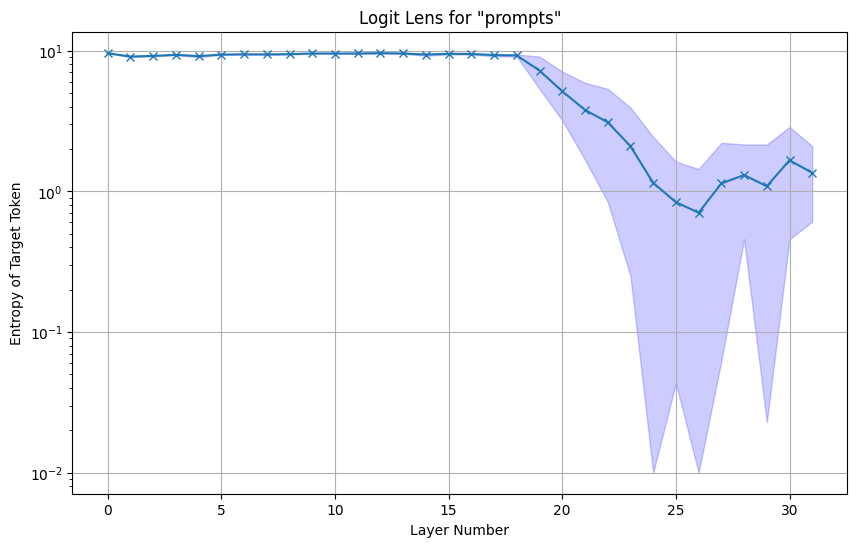

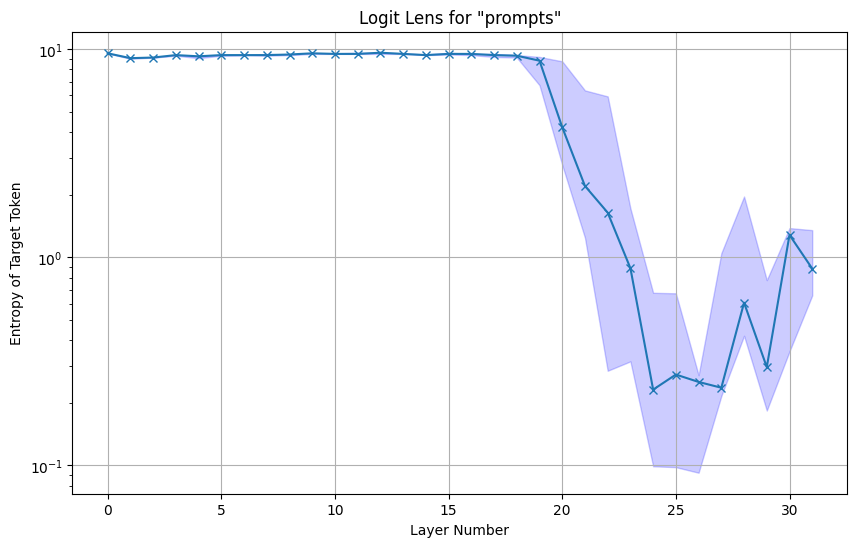

In [152]:
def compute_conf_interval(data):
    n = data.shape[0]  # Number of samples
    se = np.std(data, axis=0, ddof=1) / np.sqrt(n)  # Standard error
    z = 1.96  # Z-value for 95% confidence
    return z * se  # Shape matches the mean shape

mean_probs  = np.mean(np.stack(prompts_token_probs), axis=0)
ci_probs = compute_conf_interval(np.stack(prompts_token_probs))
lower_bound = mean_probs-ci_probs
upper_bound = mean_probs+ci_probs
plot_lens("prompts",None, None, mean_probs, plot_type='probs', lower_bound=lower_bound,upper_bound=upper_bound)

mean_entropy = np.mean(np.stack(prompts_token_entropy), axis=0)
ci_entropy = compute_conf_interval(np.stack(prompts_token_entropy))
# ci_entropy = np.std(np.stack(prompts_token_entropy), axis=0, ddof=1)
lower_bound = mean_entropy-ci_entropy
upper_bound = mean_entropy+ci_entropy
plot_lens("prompts",None, None, mean_entropy, plot_type='entropy', lower_bound=lower_bound,upper_bound=upper_bound)

median_entropy=np.percentile(np.stack(prompts_token_entropy), 50, axis=0)
lower_bound=np.percentile(np.stack(prompts_token_entropy), 25, axis=0)
upper_bound=np.percentile(np.stack(prompts_token_entropy), 75, axis=0)
plot_lens("prompts",None, None, median_entropy, plot_type='entropy', lower_bound=lower_bound,upper_bound=upper_bound)

